In [1]:
# Cài thư viện vẽ cây với Graphviz (nếu cần layout đẹp)
!apt-get -qq install -y graphviz
!pip install pydot

# Cài các thư viện Python phổ biến
!pip install networkx matplotlib numpy tqdm

In [2]:
import json

TRAIN_DATA_PATH = '/kaggle/input/py150k-1/python100k_train.json' 

# Đọc một dòng đầu tiên (một AST)
with open(TRAIN_DATA_PATH, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()

ast = json.loads(first_line)
print("Số node trong AST đầu tiên:", len(ast))
print("Node đầu [0]:", ast[0])
print("Node cuối [-1]:", ast[-1])

Số node trong AST đầu tiên: 116
Node đầu [0]: {'type': 'Module', 'children': [1, 3, 5, 7, 9, 11]}
Node cuối [-1]: {'type': 'NameLoad', 'value': 'NotFound'}


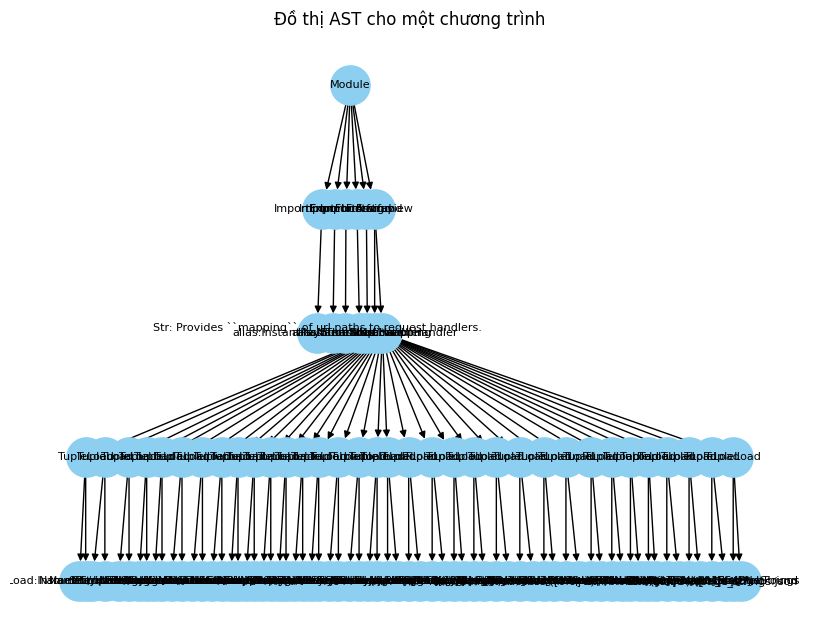

In [3]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

# Giả sử biến ast chứa danh sách node của AST (như đã đọc ở trên)
# Xây dựng đồ thị NetworkX
G = nx.DiGraph()  # dùng đồ thị có hướng (cha -> con)
for idx, node in enumerate(ast):
    # Tạo nhãn hiển thị: type hoặc type:value nếu có value
    label = node['type']
    if 'value' in node:
        label += f":{node['value']}"
    G.add_node(idx, label=label)
    for child_idx in node.get('children', []):
        G.add_edge(idx, child_idx)

# Tính tọa độ các node dùng Graphviz (cây dọc)
pos = graphviz_layout(G, prog='dot')  
plt.figure(figsize=(8, 6))
nx.draw(G, pos, labels=nx.get_node_attributes(G, 'label'), node_size=800, 
        node_color="#8dcff0", font_size=8, font_color="black", arrows=True)
plt.title("Đồ thị AST cho một chương trình")
plt.axis('off')
plt.show()

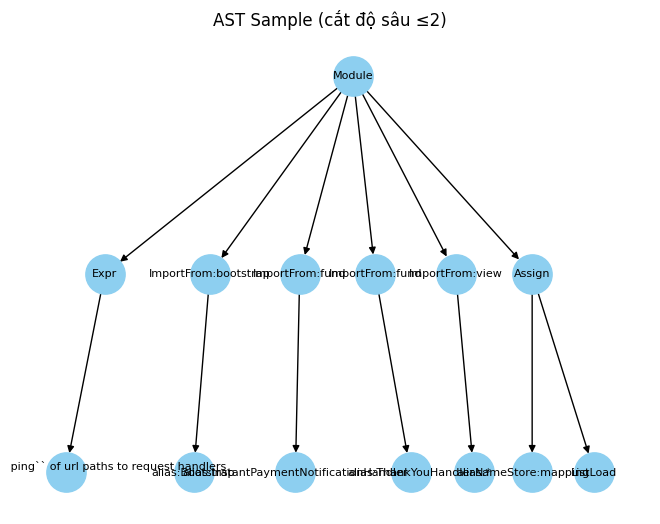

In [4]:
max_depth = 2
nodes_to_draw = set()
def traverse(node_index, depth):
    if depth > max_depth:
        return
    nodes_to_draw.add(node_index)
    for child_idx in ast[node_index].get('children', []):
        traverse(child_idx, depth+1)

traverse(0, depth=0)  # bắt đầu từ node gốc (0) độ sâu 0
H = G.subgraph(nodes_to_draw)
pos = graphviz_layout(H, prog='dot')
nx.draw(H, pos, labels=nx.get_node_attributes(H, 'label'), node_size=800, 
        node_color="#8dcff0", font_size=8, font_color="black")
plt.title(f"AST Sample (cắt độ sâu ≤{max_depth})")
plt.axis('off')
plt.show()

In [5]:
import json
from collections import Counter

# Đọc một số lượng giới hạn AST từ file (ví dụ 10000 AST đầu)
max_samples = 10000
node_counts = []        # danh sách số node của mỗi AST
leaf_counts = []        # danh sách số lá của mỗi AST
depths = []             # danh sách độ sâu của mỗi AST
distinct_type_counts = []  # số loại node độc nhất trong mỗi AST
type_counter = Counter()   # đếm tần suất xuất hiện của các loại node trên toàn bộ mẫu

def compute_depth(ast):
    """Tính độ sâu của cây AST (node gốc depth=1)."""
    if not ast:
        return 0
    max_d = 0
    # Duyệt BFS từ node gốc
    from collections import deque
    queue = deque([(0, 1)])  # (node_index, depth)
    while queue:
        idx, d = queue.popleft()
        if d > max_d:
            max_d = d
        for child_idx in ast[idx].get('children', []):
            queue.append((child_idx, d+1))
    return max_d

with open(TRAIN_DATA_PATH, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= max_samples:
            break
        ast = json.loads(line)
        # Số node
        n = len(ast)
        node_counts.append(n)
        # Số node lá (node không có children)
        leaf_count = sum(1 for node in ast if not node.get('children'))
        leaf_counts.append(leaf_count)
        # Độ sâu cây
        depth = compute_depth(ast)
        depths.append(depth)
        # Số loại node độc nhất
        distinct_types = {node['type'] for node in ast}
        distinct_type_counts.append(len(distinct_types))
        # Cập nhật bộ đếm loại node toàn cục
        for node in ast:
            type_counter[node['type']] += 1

# Tính trung bình các đặc trưng
avg_nodes = sum(node_counts) / len(node_counts)
avg_leaves = sum(leaf_counts) / len(leaf_counts)
avg_depth = sum(depths) / len(depths)
avg_types = sum(distinct_type_counts) / len(distinct_type_counts)
print(f"Trung bình số node mỗi AST: {avg_nodes:.2f}")
print(f"Trung bình số lá mỗi AST: {avg_leaves:.2f}")
print(f"Độ sâu trung bình mỗi AST: {avg_depth:.2f}")
print(f"Số loại node khác nhau (trung bình): {avg_types:.2f}")

# Top 10 loại node phổ biến nhất (trên mẫu)
top10 = type_counter.most_common(10)
print("Top 10 loại node phổ biến:")
for node_type, freq in top10:
    print(f"  {node_type}: {freq}")

Trung bình số node mỗi AST: 606.48
Trung bình số lá mỗi AST: 319.66
Độ sâu trung bình mỗi AST: 12.07
Số loại node khác nhau (trung bình): 30.74
Top 10 loại node phổ biến:
  NameLoad: 1196831
  attr: 606176
  AttributeLoad: 557996
  Str: 488048
  Call: 446068
  Assign: 259811
  NameStore: 248198
  body: 216137
  Num: 197336
  Expr: 174228


In [6]:
labels = []  # danh sách nhãn class cho mỗi AST
for n in node_counts:   # duyệt qua danh sách số node của từng AST (đã tính ở trên)
    if n < 20:
        labels.append(0)
    elif n < 50:
        labels.append(1)
    else:
        labels.append(2)

# Thống kê số lượng AST mỗi class
from collections import Counter
class_counts = Counter(labels)
print("Số lượng AST theo class:", class_counts)

Số lượng AST theo class: Counter({2: 7963, 1: 1381, 0: 656})


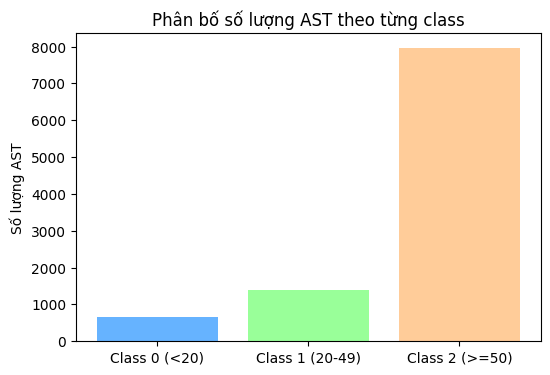

In [7]:
import matplotlib.pyplot as plt

counts = [class_counts[0], class_counts[1], class_counts[2]]
classes = ["Class 0 (<20)", "Class 1 (20-49)", "Class 2 (>=50)"]
plt.figure(figsize=(6,4))
plt.bar(range(len(classes)), counts, color=['#66b3ff','#99ff99','#ffcc99'])
plt.xticks(range(len(classes)), classes)
plt.ylabel("Số lượng AST")
plt.title("Phân bố số lượng AST theo từng class")
plt.show()